# Predicting Line Item Values for Antiretroviral (AVR) and HIV Lab Purchases
## Northwest Missouri State University (NWMSU): MS Data Analytics Capstone
## Abby Lloyd
### abbylloyd03@gmail.com
### https://github.com/abbylloyd03

## Summary
----------

This project attempts to develop a machine learning model that predicts line-item value (US$) for orders of antiretroviral drugs and HIV lab supplies that are to be shipped to countries negatively affected by the HIV/AIDS endemic. The data set used to develop the model was provided by The United States Agency for International Development (USAID). The number of features was intentionally minimized so that early estimations could be made based on limited knowledge of order details. Features include items such as quantity of order and specific characteristics of the order (brand, test kit vs. medication, adult vs. pediatric medication, and dosage form). While multiple machine learning models were developed, the best performing model was a Random Forest Regression optimized with the use of a grid search with cross validation. While the model performed fairly well on the data set as a whole (with a r-squared value of 73.19 on the test set), performance of the model declined as the line-item value increased. Because the absolute error became unacceptable as the line-item value increased, further work is needed to improve performance at the upper end of the values.

## Part One: Import Data
--------

In [1]:
# Import necessary packages
import pandas as pd
from sodapy import Socrata

# Access and load data from API
# API documentation: https://dev.socrata.com/foundry/data.usaid.gov/a3rc-nmf6
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.usaid.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.usaid.gov,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("a3rc-nmf6", limit=20000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

## Part Two: Inspect Data
--------

In [2]:
results_df.describe()

,id,project_code,pq,po_so,asn_dn,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,dosage,line_item_insurance_usd
count,10324,10324,10324,10324,10324,10324,10324,10324,10324,9964,...,10324,10324,10324,10324,10324,10324,10324,10324,8588,10037
unique,10324,142,1237,6233,7030,43,4,2,8,4,...,5065,8741,1175,183,88,2,4688,6733,54,6722
top,1,116-ZA-T30,Pre-PQ Process,SCMS-199289,ASN-19166,South Africa,PMO - US,From RDC,N/A - From RDC,Air,...,10000,200000.0,32.0,0.04,"Aurobindo Unit III, India",True,Weight Captured Separately,Freight Included in Commodity Cost,300mg,0.0
freq,1,768,2681,67,54,1406,10265,5404,5404,6113,...,93,29,368,713,3172,7030,1507,1442,990,54


In [3]:
results_df.head()

,id,project_code,pq,po_so,asn_dn,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,dosage,line_item_insurance_usd
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,19,551.0,29.0,0.97,Ranbaxy Fine Chemicals LTD,True,13,780.34,NaN,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,1000,6200.0,6.2,0.03,"Aurobindo Unit III, India",True,358,4521.5,10mg/ml,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,500,40000.0,80.0,0.8,ABBVIE GmbH & Co.KG Wiesbaden,True,171,1653.78,NaN,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",True,1855,16007.06,150mg,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,38000,121600.0,3.2,0.05,"Aurobindo Unit III, India",True,7590,45450.08,30mg,NaN


In [4]:
results_df.columns

Index(['id', 'project_code', 'pq', 'po_so', 'asn_dn', 'country', 'managed_by',
       'fulfill_via', 'vendor_inco_term', 'shipment_mode',
       'pq_first_sent_to_client_date', 'po_sent_to_vendor_date',
       'scheduled_delivery_date', 'delivered_to_client_date',
       'delivery_recorded_date', 'product_group', 'sub_classification',
       'vendor', 'item_description', 'molecule_test_type', 'brand',
       'dosage_form', 'unit_of_measure_per_pack', 'line_item_quantity',
       'line_item_value', 'pack_price', 'unit_price', 'manufacturing_site',
       'first_line_designation', 'weight_kilograms', 'freight_cost_usd',
       'dosage', 'line_item_insurance_usd'],
      dtype='object')

## Part Three: Clean Data For Use In Model
-------

### Step 1. Remove columns that are not neccesary

In [5]:
columns_to_drop = ['id', 'po_so', 'pq', 'project_code', 'asn_dn', 'country', 'managed_by', 'vendor_inco_term', 'pack_price', 
                    'shipment_mode', 'first_line_designation', 'unit_of_measure_per_pack',
                   'line_item_insurance_usd', 'fulfill_via', 'pq_first_sent_to_client_date',
                   'po_sent_to_vendor_date', 'scheduled_delivery_date', 'delivered_to_client_date',
                   'delivery_recorded_date', 'pack_price', 'unit_price', 'manufacturing_site', 'first_line_designation',
                   'weight_kilograms', 'freight_cost_usd', 'line_item_insurance_usd', 'dosage', 'item_description', 'vendor',
                   'molecule_test_type']

selected_df = results_df.drop(columns_to_drop, axis=1)


In [6]:
selected_df.columns

Index(['product_group', 'sub_classification', 'brand', 'dosage_form',
       'line_item_quantity', 'line_item_value'],
      dtype='object')

### Step 2: Identify Any Null Values

In [7]:
selected_df.isnull().sum()

product_group         0
sub_classification    0
brand                 0
dosage_form           0
line_item_quantity    0
line_item_value       0
dtype: int64

### Step 3: One-Hot Encode Categorical Colymns

In [8]:
selected_df.dtypes

product_group         object
sub_classification    object
brand                 object
dosage_form           object
line_item_quantity    object
line_item_value       object
dtype: object

In [9]:
selected_df['product_group'].unique()

array(['HRDT', 'ARV', 'ACT', 'MRDT', 'ANTM'], dtype=object)

In [10]:
# Encode 
y = pd.get_dummies(selected_df.product_group, prefix='pg')
# Drop old column
selected_df = selected_df.drop('product_group',axis = 1)
# Join the one-hot values with the df
selected_df = selected_df.join(y)
# Inspect results
selected_df.head()

,sub_classification,brand,dosage_form,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT
0,HIV test,Reveal,Test kit,19,551.0,0,0,0,1,0
1,Pediatric,Generic,Oral suspension,1000,6200.0,0,0,1,0,0
2,HIV test,Determine,Test kit,500,40000.0,0,0,0,1,0
3,Adult,Generic,Tablet,31920,127360.8,0,0,1,0,0
4,Adult,Generic,Capsule,38000,121600.0,0,0,1,0,0


In [11]:
selected_df['sub_classification'].unique()

array(['HIV test', 'Pediatric', 'Adult', 'HIV test - Ancillary', 'ACT',
       'Malaria'], dtype=object)

In [12]:
# Encode 
y = pd.get_dummies(selected_df.sub_classification, prefix='sc')
# Drop old column
selected_df = selected_df.drop('sub_classification',axis = 1)
# Join the one-hot values with the df
selected_df = selected_df.join(y)
# Inspect results
selected_df.head()

,brand,dosage_form,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT,sc_ACT,sc_Adult,sc_HIV test,sc_HIV test - Ancillary,sc_Malaria,sc_Pediatric
0,Reveal,Test kit,19,551.0,0,0,0,1,0,0,0,1,0,0,0
1,Generic,Oral suspension,1000,6200.0,0,0,1,0,0,0,0,0,0,0,1
2,Determine,Test kit,500,40000.0,0,0,0,1,0,0,0,1,0,0,0
3,Generic,Tablet,31920,127360.8,0,0,1,0,0,0,1,0,0,0,0
4,Generic,Capsule,38000,121600.0,0,0,1,0,0,0,1,0,0,0,0


In [13]:
selected_df['brand'].unique()

array(['Reveal', 'Generic', 'Determine', 'Stocrin/Sustiva', 'Aluvia',
       'Uni-Gold', 'InstantCHEK', 'Videx', 'First Response', 'Stat-Pak',
       'OraQuick', 'Bioline', 'Retrovir', 'Viread', 'Zerit', 'Capillus',
       'Genie', 'Invirase', 'Videx EC', 'Ziagen', 'Coartem', 'Viramune',
       'Paramax', 'Atripla', 'Kaletra', 'Epivir', 'Norvir', 'Truvada',
       'Clearview', 'Colloidal Gold', 'INSTi', 'Trizivir', 'Visitect',
       'Viracept', 'DoubleCheck', 'Bundi', 'ImmunoComb', 'Crixivan',
       'LAV', 'Pepti-LAV', 'Intelence', 'Prezista', 'Isentress',
       'Reyataz', 'Combivir', 'Multispot', 'CareStart', 'Hexagon'],
      dtype=object)

In [14]:
# Encode 
y = pd.get_dummies(selected_df.brand, prefix='brand')
# Drop old column
selected_df = selected_df.drop('brand',axis = 1)
# Join the one-hot values with the df
selected_df = selected_df.join(y)
# Inspect results
selected_df.head()

,dosage_form,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT,sc_ACT,sc_Adult,...,brand_Truvada,brand_Uni-Gold,brand_Videx,brand_Videx EC,brand_Viracept,brand_Viramune,brand_Viread,brand_Visitect,brand_Zerit,brand_Ziagen
0,Test kit,19,551.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Oral suspension,1000,6200.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Test kit,500,40000.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Tablet,31920,127360.8,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Capsule,38000,121600.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
selected_df['dosage_form'].unique()

array(['Test kit', 'Oral suspension', 'Tablet', 'Capsule',
       'Oral solution', 'Tablet - FDC', 'Powder for oral solution',
       'Test kit - Ancillary', 'Chewable/dispersible tablet',
       'Delayed-release capsules - blister', 'Tablet - blister',
       'Tablet - FDC + blister', 'Tablet - FDC + co-blister', 'Injection',
       'Delayed-release capsules', 'Chewable/dispersible tablet - FDC',
       'Oral powder'], dtype=object)

In [16]:
# Encode 
y = pd.get_dummies(selected_df.dosage_form, prefix='df')
# Drop old column
selected_df = selected_df.drop('dosage_form',axis = 1)
# Join the one-hot values with the df
selected_df = selected_df.join(y)
# Inspect results
selected_df.head()

,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT,sc_ACT,sc_Adult,sc_HIV test,...,df_Oral solution,df_Oral suspension,df_Powder for oral solution,df_Tablet,df_Tablet - FDC,df_Tablet - FDC + blister,df_Tablet - FDC + co-blister,df_Tablet - blister,df_Test kit,df_Test kit - Ancillary
0,19,551.0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1000,6200.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,500,40000.0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,31920,127360.8,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,38000,121600.0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Step 4: Change numeric columns to floats/integers

In [17]:
selected_df[['line_item_quantity', 'line_item_value']] = selected_df[['line_item_quantity', 'line_item_value']].apply(pd.to_numeric)
selected_df.dtypes

line_item_quantity                int64
line_item_value                 float64
pg_ACT                            uint8
pg_ANTM                           uint8
pg_ARV                            uint8
                                 ...   
df_Tablet - FDC + blister         uint8
df_Tablet - FDC + co-blister      uint8
df_Tablet - blister               uint8
df_Test kit                       uint8
df_Test kit - Ancillary           uint8
Length: 78, dtype: object

### Step 5: Inspect All Numeric Columns for Outliers & Remove Outliers

<AxesSubplot:ylabel='Frequency'>

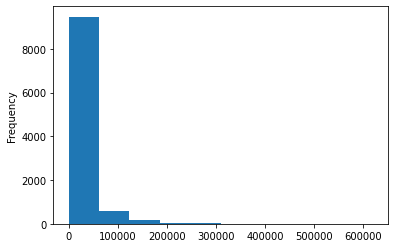

In [18]:
# View histogram
selected_df['line_item_quantity'].plot.hist()

<AxesSubplot:>

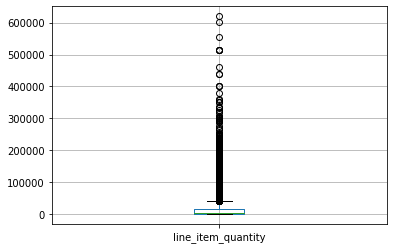

In [19]:
# View boxplot
selected_df.boxplot(column='line_item_quantity')

In [20]:
# Describe data
selected_df['line_item_quantity'].describe()

count     10324.000000
mean      18332.534870
std       40035.302961
min           1.000000
25%         408.000000
50%        3000.000000
75%       17039.750000
max      619999.000000
Name: line_item_quantity, dtype: float64

In [21]:
# Identify upper and lower limits
Q1 = selected_df['line_item_quantity'].quantile(0.25)
Q3 = selected_df['line_item_quantity'].quantile(0.75)
IQR = Q3 - Q1

Lower = Q1 - 1.5 * IQR
Upper = Q3 + 1.5 * IQR

print(f'lower limit: {Lower}, upper limit: {Upper}')

lower limit: -24539.625, upper limit: 41987.375


In [22]:
# Remove outliers
outliers_low = (selected_df['line_item_quantity'] < Lower)
outliers_upper = (selected_df['line_item_quantity'] > Upper)
selected_df = selected_df[~(outliers_low | outliers_upper)]

<AxesSubplot:ylabel='Frequency'>

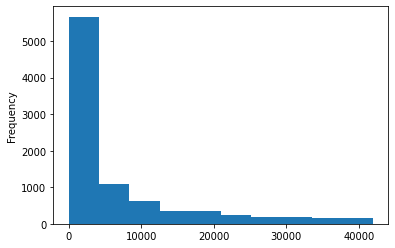

In [23]:
# View histogram with outliers removed
selected_df['line_item_quantity'].plot.hist()

<AxesSubplot:>

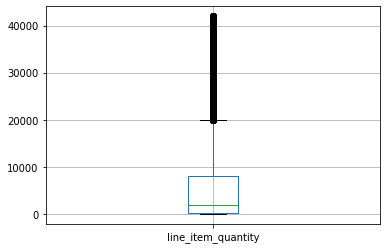

In [24]:
# View boxplot
selected_df.boxplot(column='line_item_quantity')

In [25]:
# Describe data
selected_df['line_item_quantity'].describe()

count     8953.000000
mean      6442.975986
std       9557.972992
min          1.000000
25%        300.000000
50%       2011.000000
75%       8149.000000
max      41949.000000
Name: line_item_quantity, dtype: float64

<AxesSubplot:ylabel='Frequency'>

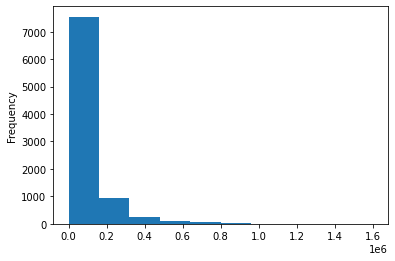

In [26]:
# View histogram
selected_df['line_item_value'].plot.hist()

<AxesSubplot:>

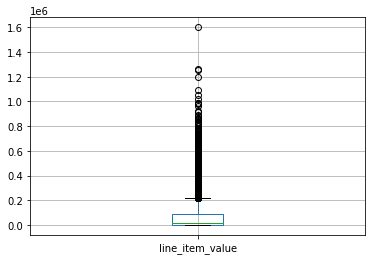

In [27]:
# View boxplot
selected_df.boxplot(column='line_item_value')

In [28]:
# Describe data
selected_df['line_item_value'].describe()

count    8.953000e+03
mean     7.474605e+04
std      1.278411e+05
min      0.000000e+00
25%      3.122550e+03
50%      1.918500e+04
75%      8.887896e+04
max      1.600000e+06
Name: line_item_value, dtype: float64

In [29]:
# Identify upper and lower limits
Q1 = selected_df['line_item_value'].quantile(0.25)
Q3 = selected_df['line_item_value'].quantile(0.75)
IQR = Q3 - Q1

Lower = Q1 - 1.5 * IQR
Upper = Q3 + 1.5 * IQR

print(f'lower limit: {Lower}, upper limit: {Upper}')

lower limit: -125512.065, upper limit: 217513.575


In [30]:
# Remove outliers
outliers_low = (selected_df['line_item_value'] < Lower)
outliers_upper = (selected_df['line_item_value'] > Upper)
selected_df = selected_df[~(outliers_low | outliers_upper)]

<AxesSubplot:ylabel='Frequency'>

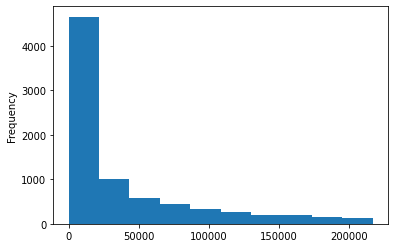

In [31]:
# View histogram
selected_df['line_item_value'].plot.hist()

<AxesSubplot:>

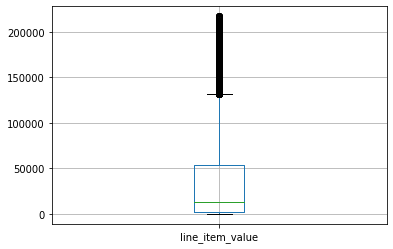

In [32]:
# View boxplot
selected_df.boxplot(column='line_item_value')

In [33]:
# Describe data
selected_df['line_item_value'].describe()

count      7962.000000
mean      37984.232975
std       51464.759421
min           0.000000
25%        2364.750000
50%       13592.500000
75%       53984.375000
max      217047.600000
Name: line_item_value, dtype: float64

### Step 6: Normalize Data

In [34]:
df_max_scaled = selected_df.copy()

In [35]:
for column in df_max_scaled.columns:
    df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()
display(df_max_scaled)

,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT,sc_ACT,sc_Adult,sc_HIV test,...,df_Oral solution,df_Oral suspension,df_Powder for oral solution,df_Tablet,df_Tablet - FDC,df_Tablet - FDC + blister,df_Tablet - FDC + co-blister,df_Tablet - blister,df_Test kit,df_Test kit - Ancillary
0,0.000453,0.002539,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.023852,0.028565,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.011926,0.184291,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.761341,0.586787,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.906359,0.560246,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10316,0.357773,0.450592,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10317,0.160378,0.096656,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10320,0.502600,0.632992,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10322,0.416567,0.524640,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Part Four: Data Exploration
------

### Step 1: Describe Data

In [36]:
df_max_scaled.describe()

,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT,sc_ACT,sc_Adult,sc_HIV test,...,df_Oral solution,df_Oral suspension,df_Powder for oral solution,df_Tablet,df_Tablet - FDC,df_Tablet - FDC + blister,df_Tablet - FDC + co-blister,df_Tablet - blister,df_Test kit,df_Test kit - Ancillary
count,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,...,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000
mean,0.118748,0.175004,0.001884,0.002763,0.824667,0.169681,0.001005,0.001884,0.588922,0.149460,...,0.089550,0.025622,0.003517,0.348405,0.201959,0.001884,0.002135,0.001256,0.150465,0.020221
std,0.188527,0.237113,0.043366,0.052496,0.380275,0.375376,0.031684,0.043366,0.492060,0.356564,...,0.285554,0.158014,0.059201,0.476495,0.401487,0.043366,0.046161,0.035420,0.357549,0.140765
min,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005104,0.010895,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.034883,0.062625,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.143109,0.248721,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Step 2: Display Correlations

In [37]:
pd.options.display.max_rows = 999
df_max_scaled.corr(method='pearson')

,line_item_quantity,line_item_value,pg_ACT,pg_ANTM,pg_ARV,pg_HRDT,pg_MRDT,sc_ACT,sc_Adult,sc_HIV test,...,df_Oral solution,df_Oral suspension,df_Powder for oral solution,df_Tablet,df_Tablet - FDC,df_Tablet - FDC + blister,df_Tablet - FDC + co-blister,df_Tablet - blister,df_Test kit,df_Test kit - Ancillary
line_item_quantity,1.000000,0.633705,0.003520,-0.026793,0.210859,-0.208711,-0.018483,0.003520,0.240272,-0.191590,...,-0.111515,0.042887,-0.032622,0.117791,0.217957,-0.021472,0.010841,-0.022006,-0.192700,-0.071261
line_item_value,0.633705,1.000000,0.004228,-0.026105,-0.061005,0.066412,-0.017164,0.004228,0.154181,0.109155,...,-0.151333,-0.072310,-0.041876,-0.004195,0.257417,0.002055,0.020953,-0.024041,0.107333,-0.099394
pg_ACT,0.003520,0.004228,1.000000,-0.002287,-0.094222,-0.019640,-0.001378,1.000000,-0.052001,-0.018212,...,-0.013625,-0.007045,-0.002581,-0.031769,-0.021856,0.799622,0.186236,-0.001541,-0.018284,-0.006241
pg_ANTM,-0.026793,-0.026105,-0.002287,1.000000,-0.114159,-0.023796,-0.001669,-0.002287,-0.063004,-0.022066,...,-0.016508,-0.008536,-0.003127,-0.008361,0.033118,0.163242,-0.002435,0.065689,-0.022153,-0.007562
pg_ARV,0.210859,-0.061005,-0.094222,-0.114159,1.000000,-0.980397,-0.068780,-0.094222,0.551899,-0.909123,...,0.144610,0.074771,0.027392,0.333008,0.223732,-0.094222,-0.000138,0.007025,-0.912713,-0.311563
pg_HRDT,-0.208711,0.066412,-0.019640,-0.023796,-0.980397,1.000000,-0.014337,-0.019640,-0.541080,0.927301,...,-0.141775,-0.073305,-0.026855,-0.330558,-0.227412,-0.019640,-0.020911,-0.016031,0.923476,0.317793
pg_MRDT,-0.018483,-0.017164,-0.001378,-0.001669,-0.068780,-0.014337,1.000000,-0.001378,-0.037959,-0.013294,...,-0.009946,-0.005143,-0.001884,-0.023190,-0.015954,-0.001378,-0.001467,-0.001125,0.075357,-0.004556
sc_ACT,0.003520,0.004228,1.000000,-0.002287,-0.094222,-0.019640,-0.001378,1.000000,-0.052001,-0.018212,...,-0.013625,-0.007045,-0.002581,-0.031769,-0.021856,0.799622,0.186236,-0.001541,-0.018284,-0.006241
sc_Adult,0.240272,0.154181,-0.052001,-0.063004,0.551899,-0.541080,-0.037959,-0.052001,1.000000,-0.501744,...,-0.375381,-0.194092,-0.071105,0.538597,0.353531,-0.052001,0.022056,0.022420,-0.503725,-0.171951
sc_HIV test,-0.191590,0.109155,-0.018212,-0.022066,-0.909123,0.927301,-0.013294,-0.018212,-0.501744,1.000000,...,-0.131468,-0.067976,-0.024903,-0.306527,-0.210880,-0.018212,-0.019391,-0.014865,0.996067,-0.060222


### Step 3: Isolate variables with correlation coefficient above 0.095 in relation to line_item_value

In [38]:
columns_x = ['line_item_value', 'line_item_quantity', 'sc_Adult', 'sc_HIV test', 'sc_HIV test - Ancillary', 
            'sc_Pediatric', 'brand_Bioline', 'brand_Determine', 'df_Capsule', 'df_Oral solution', 'df_Tablet - FDC',
            'df_Test kit', 'df_Test kit - Ancillary']

df_max_scaled[columns_x].corr(method='pearson')

,line_item_value,line_item_quantity,sc_Adult,sc_HIV test,sc_HIV test - Ancillary,sc_Pediatric,brand_Bioline,brand_Determine,df_Capsule,df_Oral solution,df_Tablet - FDC,df_Test kit,df_Test kit - Ancillary
line_item_value,1.000000,0.633705,0.154181,0.109155,-0.099394,-0.233374,0.098341,0.092419,-0.158340,-0.151333,0.257417,0.107333,-0.099394
line_item_quantity,0.633705,1.000000,0.240272,-0.191590,-0.071261,-0.089622,-0.014093,-0.132059,-0.108088,-0.111515,0.217957,-0.192700,-0.071261
sc_Adult,0.154181,0.240272,1.000000,-0.501744,-0.171951,-0.664766,-0.139033,-0.303501,-0.040033,-0.375381,0.353531,-0.503725,-0.171951
sc_HIV test,0.109155,-0.191590,-0.501744,1.000000,-0.060222,-0.232818,0.264806,0.495479,-0.131266,-0.131468,-0.210880,0.996067,-0.060222
sc_HIV test - Ancillary,-0.099394,-0.071261,-0.171951,-0.060222,1.000000,-0.079788,0.014454,0.240721,-0.044986,-0.045055,-0.072270,-0.060459,1.000000
sc_Pediatric,-0.233374,-0.089622,-0.664766,-0.232818,-0.079788,1.000000,-0.064514,-0.140830,0.175753,0.564682,-0.209378,-0.233738,-0.079788
brand_Bioline,0.098341,-0.014093,-0.139033,0.264806,0.014454,-0.064514,1.000000,-0.029454,-0.036374,-0.036430,-0.058435,0.263750,0.014454
brand_Determine,0.092419,-0.132059,-0.303501,0.495479,0.240721,-0.140830,-0.029454,1.000000,-0.079401,-0.079524,-0.127559,0.493401,0.240721
df_Capsule,-0.158340,-0.108088,-0.040033,-0.131266,-0.044986,0.175753,-0.036374,-0.079401,1.000000,-0.098207,-0.157527,-0.131784,-0.044986
df_Oral solution,-0.151333,-0.111515,-0.375381,-0.131468,-0.045055,0.564682,-0.036430,-0.079524,-0.098207,1.000000,-0.157770,-0.131987,-0.045055


<AxesSubplot:>

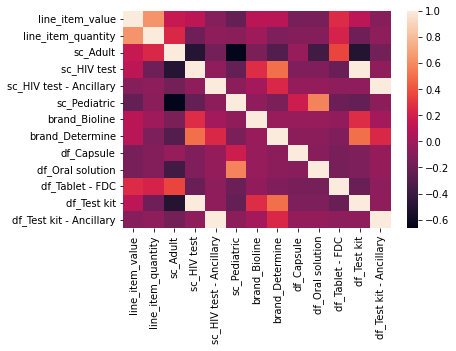

In [39]:
import seaborn as sns

#plt.matshow(df_max_scaled[columns_x].corr())
#plt.show()

cor_matrix = df_max_scaled[columns_x].corr()

sns.heatmap(cor_matrix, xticklabels=cor_matrix.columns, yticklabels=cor_matrix.columns)

### Step 4: Display Histograms

array([[<AxesSubplot:title={'center':'line_item_value'}>,
        <AxesSubplot:title={'center':'line_item_quantity'}>]],
      dtype=object)

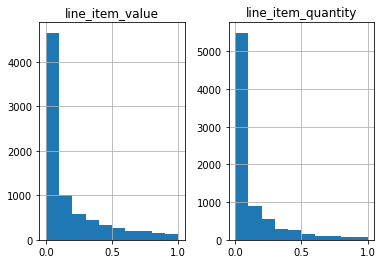

In [40]:
df_max_scaled[['line_item_value', 'line_item_quantity']].hist()

array([[<AxesSubplot:title={'center':'sc_HIV test - Ancillary'}>,
        <AxesSubplot:title={'center':'sc_Pediatric'}>]], dtype=object)

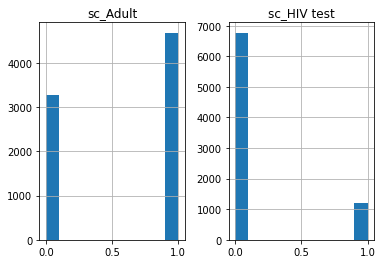

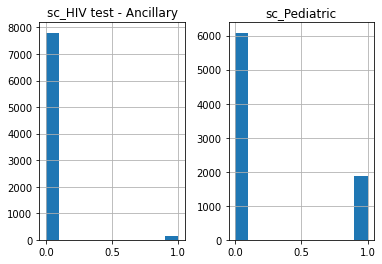

In [41]:
df_max_scaled[['sc_Adult', 'sc_HIV test']].hist()
df_max_scaled[['sc_HIV test - Ancillary', 'sc_Pediatric']].hist()

array([[<AxesSubplot:title={'center':'brand_Bioline'}>,
        <AxesSubplot:title={'center':'brand_Determine'}>]], dtype=object)

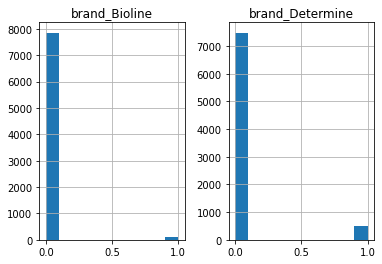

In [42]:
df_max_scaled[['brand_Bioline', 'brand_Determine']].hist()

array([[<AxesSubplot:title={'center':'df_Test kit - Ancillary'}>]],
      dtype=object)

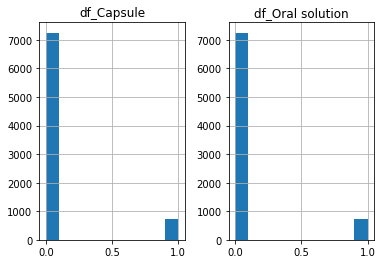

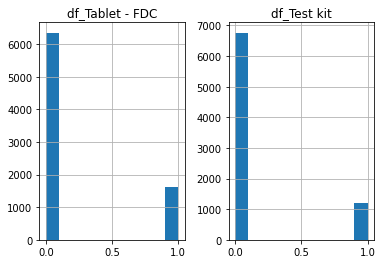

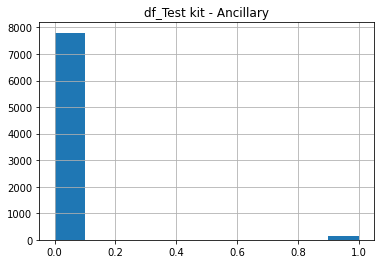

In [43]:
df_max_scaled[['df_Capsule', 'df_Oral solution']].hist()
df_max_scaled[['df_Tablet - FDC', 'df_Test kit']].hist()
df_max_scaled[['df_Test kit - Ancillary']].hist()

### Step 5: Visualize scatter plots of line_item_quantity vs. line_item_value

<AxesSubplot:xlabel='line_item_quantity', ylabel='line_item_value'>

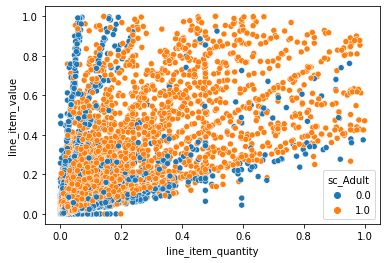

In [44]:
sns.scatterplot(data=df_max_scaled, x='line_item_quantity', y='line_item_value', hue='sc_Adult')

<AxesSubplot:xlabel='line_item_quantity', ylabel='line_item_value'>

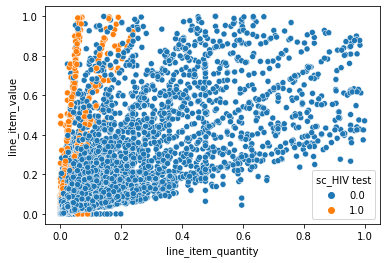

In [45]:
sns.scatterplot(data=df_max_scaled, x='line_item_quantity', y='line_item_value', hue='sc_HIV test')

<AxesSubplot:xlabel='line_item_quantity', ylabel='line_item_value'>

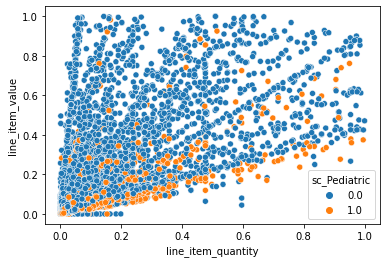

In [46]:
sns.scatterplot(data=df_max_scaled, x='line_item_quantity', y='line_item_value', hue='sc_Pediatric')

<AxesSubplot:xlabel='line_item_quantity', ylabel='line_item_value'>

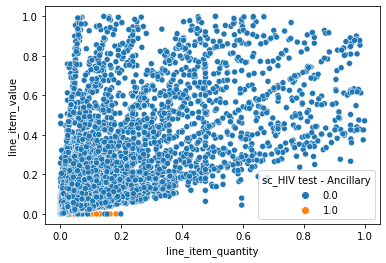

In [47]:
sns.scatterplot(data=df_max_scaled, x='line_item_quantity', y='line_item_value', hue='sc_HIV test - Ancillary')

<AxesSubplot:xlabel='line_item_quantity', ylabel='line_item_value'>

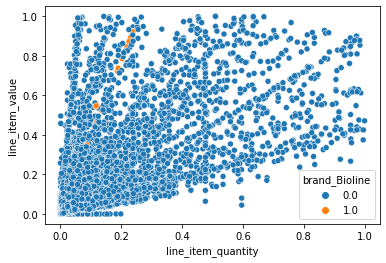

In [48]:
sns.scatterplot(data=df_max_scaled, x='line_item_quantity', y='line_item_value', hue='brand_Bioline')

<AxesSubplot:xlabel='line_item_quantity', ylabel='line_item_value'>

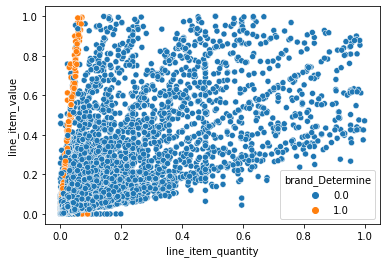

In [49]:
sns.scatterplot(data=df_max_scaled, x='line_item_quantity', y='line_item_value', hue='brand_Determine')

<AxesSubplot:xlabel='line_item_quantity', ylabel='line_item_value'>

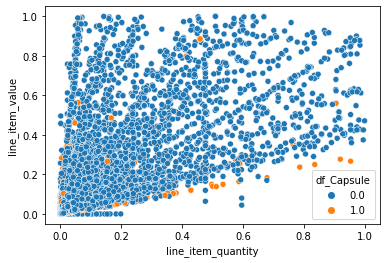

In [50]:
sns.scatterplot(data=df_max_scaled, x='line_item_quantity', y='line_item_value', hue='df_Capsule')

<AxesSubplot:xlabel='line_item_quantity', ylabel='line_item_value'>

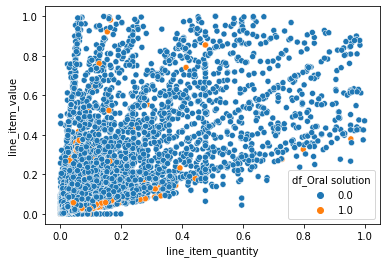

In [51]:
sns.scatterplot(data=df_max_scaled, x='line_item_quantity', y='line_item_value', hue='df_Oral solution')

<AxesSubplot:xlabel='line_item_quantity', ylabel='line_item_value'>

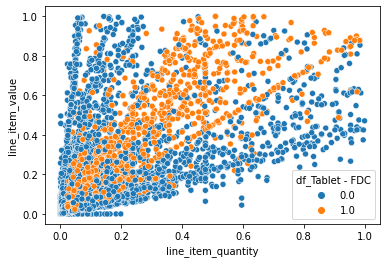

In [52]:
sns.scatterplot(data=df_max_scaled, x='line_item_quantity', y='line_item_value', hue='df_Tablet - FDC')

<AxesSubplot:xlabel='line_item_quantity', ylabel='line_item_value'>

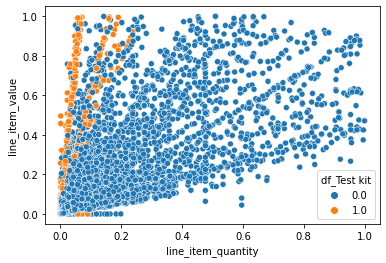

In [53]:
sns.scatterplot(data=df_max_scaled, x='line_item_quantity', y='line_item_value', hue='df_Test kit')

<AxesSubplot:xlabel='line_item_quantity', ylabel='line_item_value'>

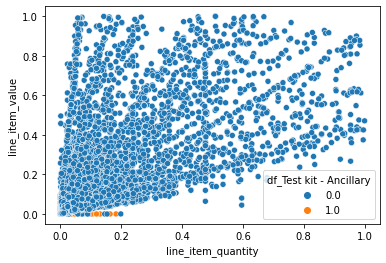

In [54]:
sns.scatterplot(data=df_max_scaled, x='line_item_quantity', y='line_item_value', hue='df_Test kit - Ancillary')

## Part Five: Create And Test Different Models
------

### Step 1: Divide data set into train and test sets

In [55]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_max_scaled, 
                        test_size=0.2, random_state=123)
print('Train size: ', len(train_set), 'Test size: ', len(test_set))

Train size:  6369 Test size:  1593


### Step 2: Select x columns

In [56]:
columns_x = ['line_item_quantity', 'sc_Adult', 'sc_HIV test', 'sc_HIV test - Ancillary', 
            'sc_Pediatric', 'brand_Bioline', 'brand_Determine', 'df_Capsule', 'df_Oral solution', 'df_Tablet - FDC',
            'df_Test kit - Ancillary']

### Step 3: Define X, y, X_test, y_test

In [57]:
X = train_set[columns_x]
y = train_set['line_item_value']

X_test = test_set[columns_x]
y_test = test_set['line_item_value']

### Step 4: Import metrics packages needed for model evaluation

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

### Step 5: Decision Tree Regressor

In [59]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor 

# build and fit the model
dt_model = DecisionTreeRegressor(random_state = 0, max_depth=5) 
dt_model.fit(X, y)

DecisionTreeRegressor(max_depth=5, random_state=0)

In [60]:
# evaluate model on training data
y_pred = dt_model.predict(X)

print('Results for decision tree regression on training data')
print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

# evaluate model on test data
y_test_pred = dt_model.predict(X_test)

print('Results for decision tree regression on test data')
print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for decision tree regression on training data
MAE is    0.07555349773978795
RMSE is   0.12625312388557322
MSE is    0.0159398512908659
R^2       0.7135144831153462
Results for decision tree regression on test data
MAE is    0.07805154482537711
RMSE is   0.13422184856987252
MSE is    0.01801550463351379
R^2       0.6921219345374461


### Step 6: Gradient Boosting Regressor

In [61]:
# import the regressor
from sklearn.ensemble import GradientBoostingRegressor

# build and fit the model
gb_model = GradientBoostingRegressor(max_depth=4) 
gb_model.fit(X, y)

GradientBoostingRegressor(max_depth=4)

In [62]:
# evaluate model on training data
y_pred = gb_model.predict(X)

print('Results for gradient boost regression on training data')
print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

# evaluate model on test data
y_test_pred = gb_model.predict(X_test)

print('Results for gradient boost regression on test data')
print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for gradient boost regression on training data
MAE is    0.06741474232489404
RMSE is   0.11448753456059219
MSE is    0.013107395569762792
R^2       0.7644219556196921
Results for gradient boost regression on test data
MAE is    0.07213421865134924
RMSE is   0.1273541137063039
MSE is    0.016219070277918184
R^2       0.7228223087641197


### Step 7: Random Forest Regressor

In [63]:
# import the regressor
from sklearn.ensemble import RandomForestRegressor

# build and fit the model
rf_model = RandomForestRegressor(random_state = 0, max_depth=7)
rf_model.fit(X, y)

RandomForestRegressor(max_depth=7, random_state=0)

In [64]:
# evaluate model on training data
y_pred = rf_model.predict(X)

print('Results for random forest regression on training data')
print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

# evaluate model on test data
y_test_pred = rf_model.predict(X_test)

print('Results for random forest regression on test data')
print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for random forest regression on training data
MAE is    0.06740647672592869
RMSE is   0.11584611068970505
MSE is    0.013420321361931394
R^2       0.7587977684375109
Results for random forest regression on test data
MAE is    0.07210853596564434
RMSE is   0.1272175084663253
MSE is    0.016184294460379545
R^2       0.7234166141497572


### Step 8: Support Vector Regressor

In [65]:
# import the regressor
from sklearn.svm import SVR

# build and fit model
svr_model = SVR(kernel='poly', degree=5) # set kernel and hyperparemeters
svr_model.fit(X, y)

SVR(degree=5, kernel='poly')

In [66]:
# evaluate model on training data
y_pred = svr_model.predict(X)

print('Results for SVR regression on training data')
print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

# evaluate model on test data
y_test_pred = svr_model.predict(X_test)

print('Results for SVR regression on test data')
print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for SVR regression on training data
MAE is    0.10143446711659562
RMSE is   0.1397771751564696
MSE is    0.019537658694722376
R^2       0.6488514134958763
Results for SVR regression on test data
MAE is    0.10122561080750916
RMSE is   0.14056219621112154
MSE is    0.019757731003693827
R^2       0.6623479539934298


### Step 9: K-Nearest Neighbor Regressor

In [67]:
# import regressor
from sklearn.neighbors import KNeighborsRegressor

# build and fit model
neigh_model = KNeighborsRegressor(n_neighbors=6)
neigh_model.fit(X, y)

KNeighborsRegressor(n_neighbors=6)

In [68]:
# evaluate model on training data
y_pred = neigh_model.predict(X)

print('Results for K Neighbors regression on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

# evaluate model on test data
y_test_pred = neigh_model.predict(X_test)

print('Results for K Neighbors regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for K Neighbors regression on training data
MAE is    0.062349181509320104
RMSE is   0.11178471748342016
MSE is    0.012495823062848061
R^2       0.7754136934068764
Results for K Neighbors regression on test data
MAE is    0.07387508430824134
RMSE is   0.13387586485492012
MSE is    0.017922747190652833
R^2       0.6937071236646027


## Part Six: Fine Tune Hyperparameters For Random Forest Regressor
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
------

### Step 1: Inspect current parameters

In [69]:
print('Parameters currently in use:\n')
print(rf_model.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


### Step 2: Grid Search with Cross Validation

In [70]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 7, 9],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 200, 300, 500]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

search = grid_search.fit(X,y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END bootstrap=True, max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.9s
[CV] END boo

In [71]:
# Inspect best estimator parameters
grid_search_rf = search.best_estimator_
print(grid_search_rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 9, 'max_features': 3, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


### Step 3: Evaluate Model

In [72]:
# evaluate model on training data
y_pred = grid_search_rf.predict(X)

print('Results for Random Forest Regression with grid search parameters on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

# evaluate model on test data
y_test_pred = grid_search_rf.predict(X_test)

print('Results for Random Forest Regression with grid search parameters on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for Random Forest Regression with grid search parameters on training data
MAE is    0.06450579740636393
RMSE is   0.11195446737326586
MSE is    0.012533802764831651
R^2       0.7747310876312423
Results for Random Forest Regression with grid search parameters on test data
MAE is    0.07059595371736528
RMSE is   0.12525424124504833
MSE is    0.01568862494987277
R^2       0.7318874160011641


## Part Seven: Fine Tune K-Nearest Neighbors Regressor
- Code for silhouette reference chart borrowed from here: https://blog.paperspace.com/svr-kmeans-clustering-for-regression/amp/
------

### Step 1: Use KMeans to Find Best Number of Custers for Model

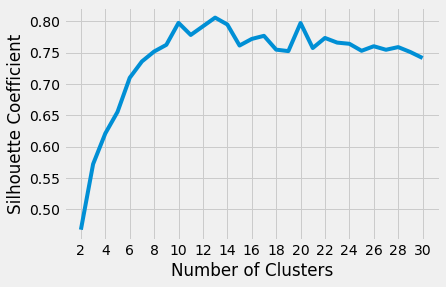

In [73]:
# import packages
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import statistics
from scipy import stats
import matplotlib.pyplot as plt


silhouette_coefficients = []

kmeans_kwargs = {
    'init': 'random',
    'n_init':30,
    'max_iter':300,
    'random_state': 42
}

# plot graph to determine the best number of clusters with the highest Silhouette Coefficient score
for k in range(2,31):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use('fivethirtyeight')
plt.plot(range(2, 31), silhouette_coefficients)
plt.xticks(range(2, 31, 2))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

### Step 2: Create & Evaluate Model

In [74]:
# import regressor
from sklearn.neighbors import KNeighborsRegressor

# build and fit model
neigh_model_tuned = KNeighborsRegressor(n_neighbors=13)
neigh_model_tuned.fit(X, y)

# evaluate model on training data
y_pred = neigh_model_tuned.predict(X)

print('Results for K Neighbors regression on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

# evaluate model on test data
y_test_pred = neigh_model_tuned.predict(X_test)

print('Results for K Neighbors regression on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for K Neighbors regression on training data
MAE is    0.06677474796287243
RMSE is   0.11779947779274497
MSE is    0.013876716968243413
R^2       0.7505950111600256
Results for K Neighbors regression on test data
MAE is    0.07243756981402281
RMSE is   0.13014556480888173
MSE is    0.01693786803942284
R^2       0.7105383306700959


## Part Eight: Combine Models to Reduce Chance of Overfitting
------

In [75]:
# evaluate model on training data
y_pred = ((grid_search_rf.predict(X) + neigh_model_tuned.predict(X)) / 2)

print('Results for Combined Model on training data')

print('MAE is   ', mean_absolute_error(y, y_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is   ', mean_squared_error(y, y_pred))
print('R^2      ', r2_score(y, y_pred))

# evaluate model on test data
y_test_pred = ((grid_search_rf.predict(X_test) + neigh_model_tuned.predict(X_test)) / 2)
print('Results for Combined Model on test data')

print('MAE is   ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is  ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is   ', mean_squared_error(y_test, y_test_pred))
print('R^2      ', r2_score(y_test, y_test_pred))

Results for Combined Model on training data
MAE is    0.06516039847082421
RMSE is   0.11367009068860809
MSE is    0.012920889517156389
R^2       0.7677740121670251
Results for Combined Model on test data
MAE is    0.07112208219159027
RMSE is   0.12656464632344294
MSE is    0.0160186096989782
R^2       0.7262481031840403


## Part Nine: Results
------

### Step 1: Results of Shortlisted Models

| Model | Training Features | R2 train | R2 test | MAE train | MAE test | MAE train (\$) | MAE test (\$) |
|:---|:---|:---|:---|:---|:---|:---|:---|
|Decision Tree Regressor|max_depth=5|71.35|69.21|7.56|7.81|\$16,408.80|\$16,951.42|
|Gradient Boosting Regressor|max_depth=3|76.44|72.29|6.74|7.21|\$14,629.00|\$15,649.13|
|Random Forest Regressor|max_depth=7|75.88|72.34|6.74|7.21|\$14,629.00|\$15,649.13|
|Support Vector Regressor|kernel=poly, degree=5|64.89|66.23|10.14|10.12|\$22,008.63|\$21,965.22|
|K-Nearest Neighbor Regressor|n_neighbors=6|77.54|69.37|6.23|7.39|\$13,522.06|\$16,039.82|

### Step 2: Results of Fine-Tuned & Combined Models

| Model | Training Features | R2 train | R2 test | MAE train | MAE test |  MAE train (\$) | MAE test (\$) |
|:---|:---|:---|:---|:---|:---|:---|:---|
|Random Forest Regression - Grid Search with CV|max_depth=9|77.47|73.19|6.45|7.06|\$13,999.57|\$15,323.56|
|K-Nearest Neighbors - Optimized Neighbors|n_neighbors=13|75.06|71.05|6.68|7.24|\$14,498.78|\$15,670.84|
|Combined Model|50/50 average|75.73|72.53|6.75|7.22|\$14,650.71|\$15,670.84|


### Step 3: Visualize MAE ($) for predicted line-item value

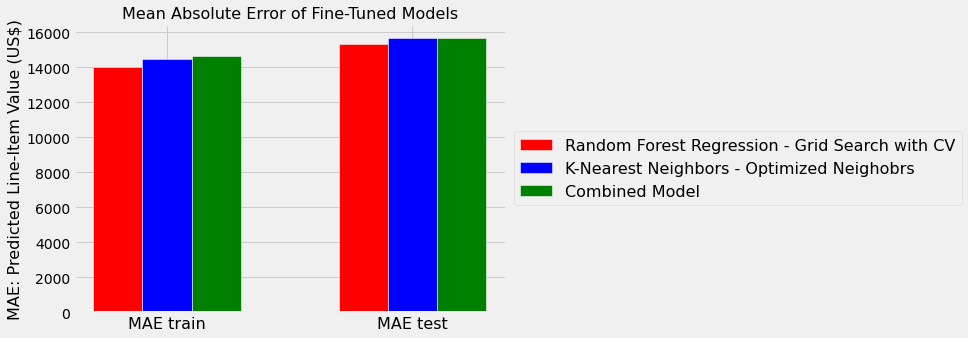

In [76]:
# bar chart developed with the assistance of ChatGPT Mar 23, 2023 version

# Create data and plot
Random_Forest_w_GridSearch = [13999.57, 15323.56]
K_Nearest_Neighbors_Optimized = [14498.78, 15670.84]
Combined_Model = [14650.71, 15670.84]
groups = ['Random_Forest_w_GridSearch', 'K-Nearest_Neighbors_Optimized', 'Combined_Model']
variables = ['MAE train', 'MAE test']

# Set width and position of bars
bar_width = 0.2
r1 = np.arange(len(Random_Forest_w_GridSearch))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create plot
plt.bar(r1, Random_Forest_w_GridSearch, color='red', width=bar_width, edgecolor='white', label='Random Forest Regression - Grid Search with CV')
plt.bar(r2, K_Nearest_Neighbors_Optimized, color='blue', width=bar_width, edgecolor='white', label='K-Nearest Neighbors - Optimized Neighobrs')
plt.bar(r3, Combined_Model, color='green', width=bar_width, edgecolor='white', label='Combined Model')

# Add xticks and labels
plt.ylabel('MAE: Predicted Line-Item Value (US$)', fontsize=16)
plt.xticks([r + bar_width for r in range(len(Random_Forest_w_GridSearch))], variables, fontsize=16)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

# Add title
plt.title('Mean Absolute Error of Fine-Tuned Models', fontsize=16)

# Adjust size
plt.subplots_adjust(left=1, right=2, top=2, bottom=1)

# Show plot
plt.show()

## Step 4: Visualize Accuracy - Random Forest Regression (Grid Search with CV)

### Step 4.1: Absolute Error Boxplot - Test Set

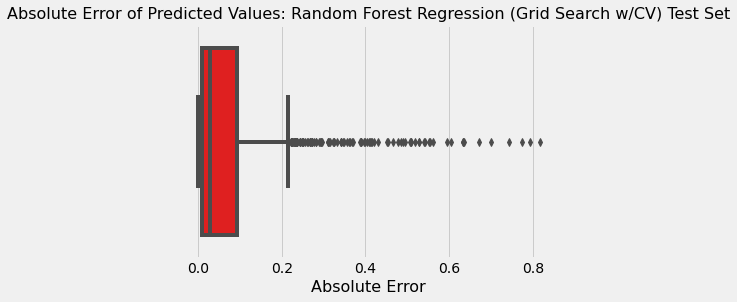

In [77]:
# Create data
abs_errors = np.abs(y_test - (grid_search_rf.predict(X_test)))

# create a boxplot
sns.boxplot(x=abs_errors, color="red")

# add labels
plt.xlabel('Absolute Error', fontsize=16)
plt.title("Absolute Error of Predicted Values: Random Forest Regression (Grid Search w/CV) Test Set", fontsize=16)

# display the plot
plt.show()

### Step 4.2 Absolute Error In Relation to Actual Line-Item Value - Test Set

Text(0, 0.5, 'Absolute error')

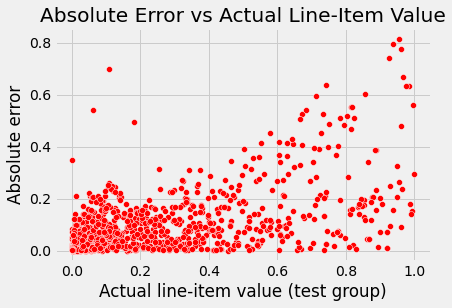

In [78]:
sns.scatterplot(x=y_test, y=abs_errors, color='red')
plt.title('Absolute Error vs Actual Line-Item Value')
plt.xlabel('Actual line-item value (test group)')
plt.ylabel('Absolute error')

### Step 4.3: Absolute Error As A Percentage of Actual Line-Item Value - Test Set

(0.0, 100.0)

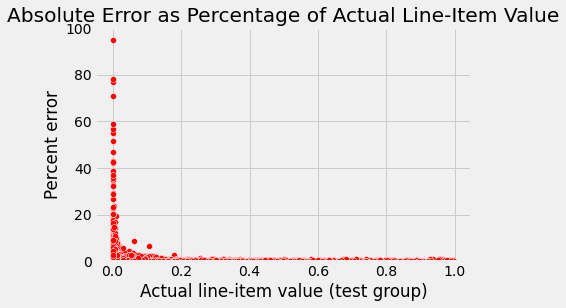

In [79]:
percent_error = abs_errors / y_test
sns.scatterplot(x=y_test, y=percent_error, color='red')

plt.title('Absolute Error as Percentage of Actual Line-Item Value')
plt.xlabel('Actual line-item value (test group)')
plt.ylabel('Percent error')
plt.ylim(0, 100)

### Step. 4.4: Box Plot - Absolute Error As A Percentange of Actual Line-Item Value

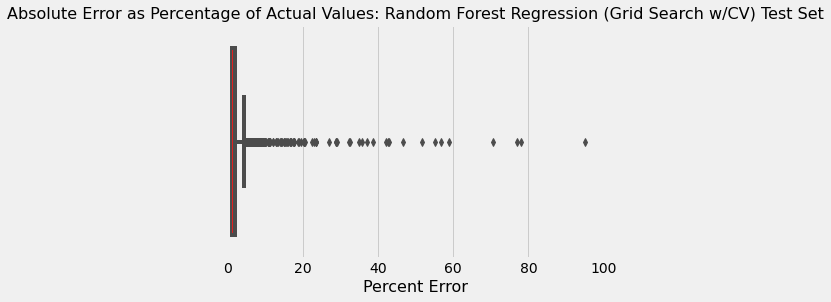

In [80]:
# create a boxplot
sns.boxplot(x=percent_error, color="red")

# add labels
plt.xlabel('Percent Error', fontsize=16)
plt.title("Absolute Error as Percentage of Actual Values: Random Forest Regression (Grid Search w/CV) Test Set", fontsize=16)
plt.xlim(0,100)


# display the plot
plt.show()

### Step. 4.5: Actual Line-Item Value vs. Predicted Line-Item Value

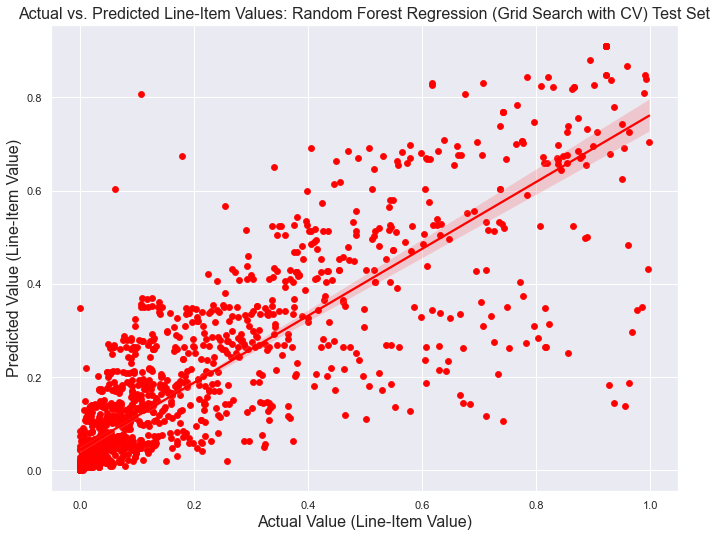

In [81]:
# scatter chart developed with the assistance of ChatGPT Mar 23, 2023 version

# create data for example
actual_values = y_test
predicted_values = grid_search_rf.predict(X_test)


# Set the figure size
sns.set(rc={"figure.figsize":(10, 8)})

# create scatter plot using Seaborn
sns.scatterplot(x=actual_values, y=predicted_values, color='red')

# add regression line
sns.regplot(x=actual_values, y=predicted_values, color='red')


# add title and axis labels
plt.title("Actual vs. Predicted Line-Item Values: Random Forest Regression (Grid Search with CV) Test Set", fontsize=16)
plt.xlabel("Actual Value (Line-Item Value)", fontsize=16)
plt.ylabel("Predicted Value (Line-Item Value)", fontsize=16)


# display the plot
plt.show()

## Step 5: Visualize Accuracy: K-Nearest Neighbors (Optimized Neighbors) - Test Set

### Step 5.1: Absolute Error Boxplot - Test Set

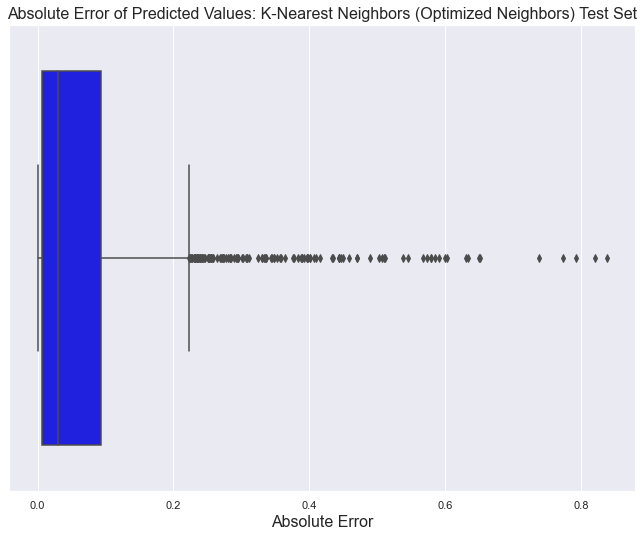

In [82]:
# Create data
abs_errors = np.abs(y_test - (neigh_model_tuned.predict(X_test)))

# create a boxplot
sns.boxplot(x=abs_errors, color="blue")

# add labels
plt.xlabel('Absolute Error', fontsize=16)
plt.title("Absolute Error of Predicted Values: K-Nearest Neighbors (Optimized Neighbors) Test Set", fontsize=16)

# display the plot
plt.show()

### Step 5.2 Absolute Error In Relation to Actual Line-Item Value - Test Set

Text(0, 0.5, 'Absolute error')

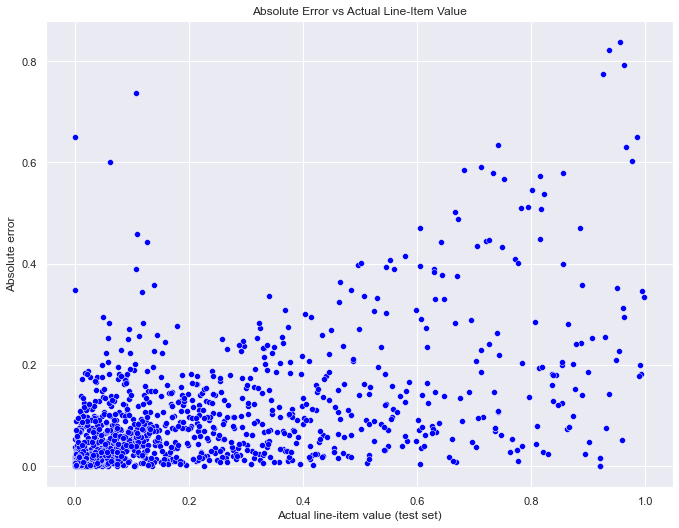

In [83]:
sns.scatterplot(x=y_test, y=abs_errors, color='blue')
plt.title('Absolute Error vs Actual Line-Item Value')
plt.xlabel('Actual line-item value (test set)')
plt.ylabel('Absolute error')

### Step 5.3: Absolute Error As A Percentage of Actual Line-Item Value - Test Set

(0.0, 100.0)

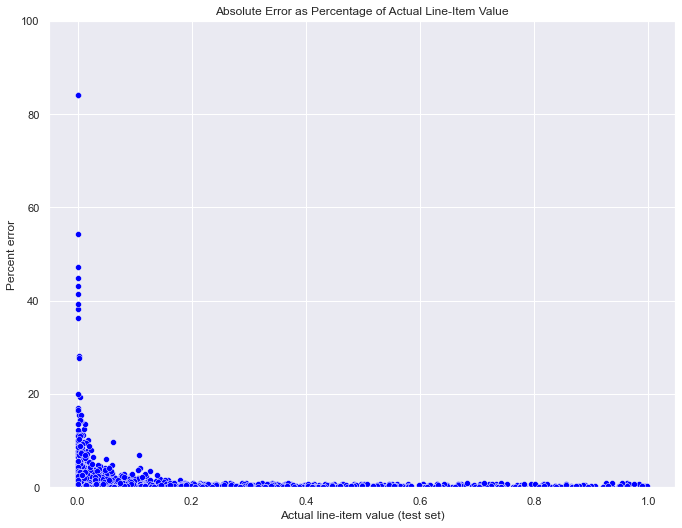

In [84]:
percent_error = abs_errors / y_test
sns.scatterplot(x=y_test, y=percent_error, color='blue')

plt.title('Absolute Error as Percentage of Actual Line-Item Value')
plt.xlabel('Actual line-item value (test set)')
plt.ylabel('Percent error')
plt.ylim(0, 100)

### Step. 5.4: Box Plot - Absolute Error As A Percentange of Actual Line-Item Value

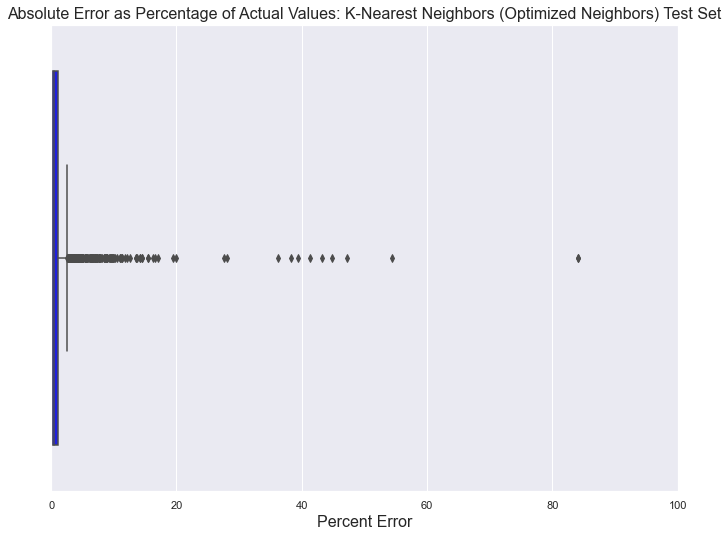

In [85]:
# create a boxplot
sns.boxplot(x=percent_error, color="blue")

# add labels
plt.xlabel('Percent Error', fontsize=16)
plt.title("Absolute Error as Percentage of Actual Values: K-Nearest Neighbors (Optimized Neighbors) Test Set", fontsize=16)
plt.xlim(0,100)


# display the plot
plt.show()

### Step 5.5: Actual Line-Item Value vs. Predicted Line-Item Value

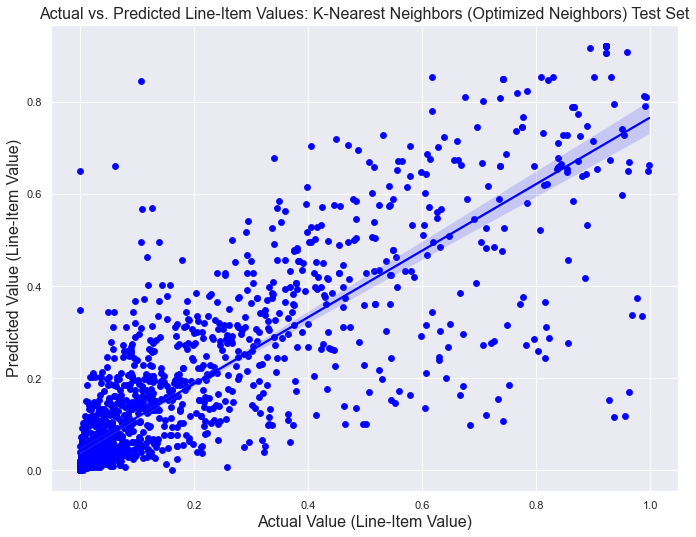

In [86]:
# scatter chart developed with the assistance of ChatGPT Mar 23, 2023 version

# create data for example
actual_values = y_test
predicted_values = neigh_model_tuned.predict(X_test)


# Set the figure size
sns.set(rc={"figure.figsize":(10, 8)})

# create scatter plot using Seaborn
sns.scatterplot(x=actual_values, y=predicted_values, color='blue')

# add regression line
sns.regplot(x=actual_values, y=predicted_values, color='blue')


# add title and axis labels
plt.title("Actual vs. Predicted Line-Item Values: K-Nearest Neighbors (Optimized Neighbors) Test Set", fontsize=16)
plt.xlabel("Actual Value (Line-Item Value)", fontsize=16)
plt.ylabel("Predicted Value (Line-Item Value)", fontsize=16)


# display the plot
plt.show()

## Step 6: Visualize Accuracy: Combined Model - Test Set

### Step 6.1: Absolute Error Boxplot - Test Set

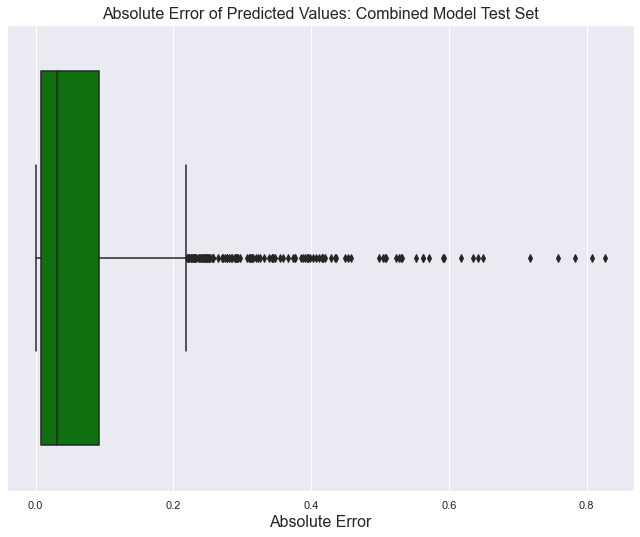

In [87]:
# Create data
abs_errors = np.abs(y_test - ((grid_search_rf.predict(X_test) + neigh_model_tuned.predict(X_test)) / 2))

# create a boxplot
sns.boxplot(x=abs_errors, color="green")

# add labels
plt.xlabel('Absolute Error', fontsize=16)
plt.title("Absolute Error of Predicted Values: Combined Model Test Set", fontsize=16)

# display the plot
plt.show()

### Step 6.2 Absolute Error In Relation to Actual Line-Item Value - Test Set

Text(0, 0.5, 'Absolute error')

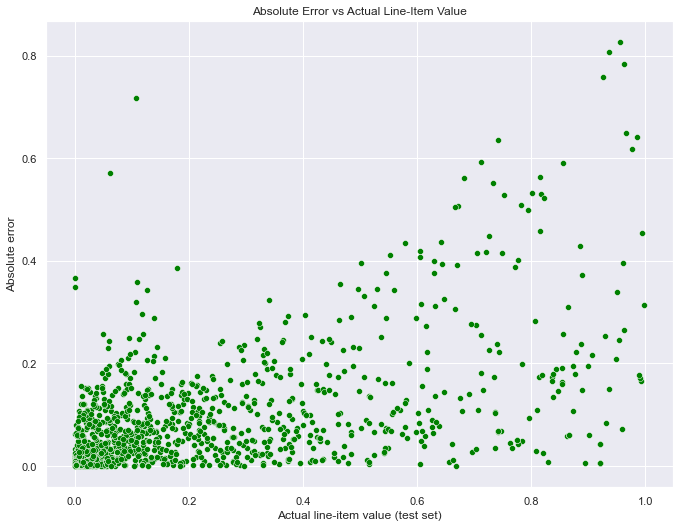

In [88]:
sns.scatterplot(x=y_test, y=abs_errors, color='green')
plt.title('Absolute Error vs Actual Line-Item Value')
plt.xlabel('Actual line-item value (test set)')
plt.ylabel('Absolute error')

### Step 6.3: Absolute Error As A Percentage of Actual Line-Item Value - Test Set

(0.0, 100.0)

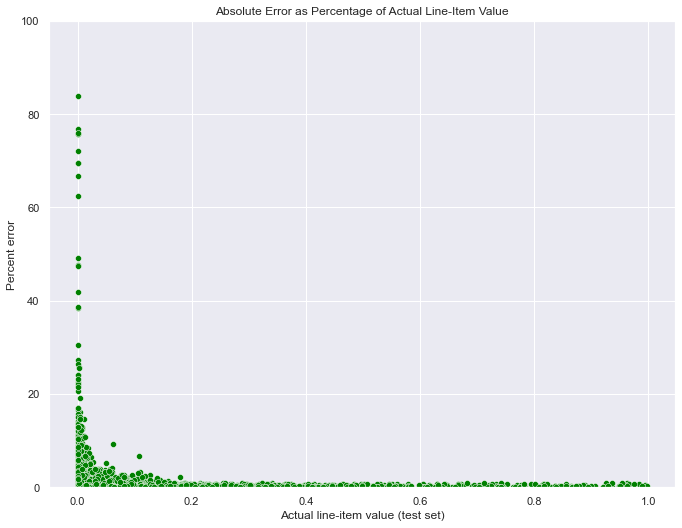

In [89]:
percent_error = abs_errors / y_test
sns.scatterplot(x=y_test, y=percent_error, color='green')

plt.title('Absolute Error as Percentage of Actual Line-Item Value')
plt.xlabel('Actual line-item value (test set)')
plt.ylabel('Percent error')
plt.ylim(0,100)

### Step. 6.4: Box Plot - Absolute Error As A Percentange of Actual Line-Item Value

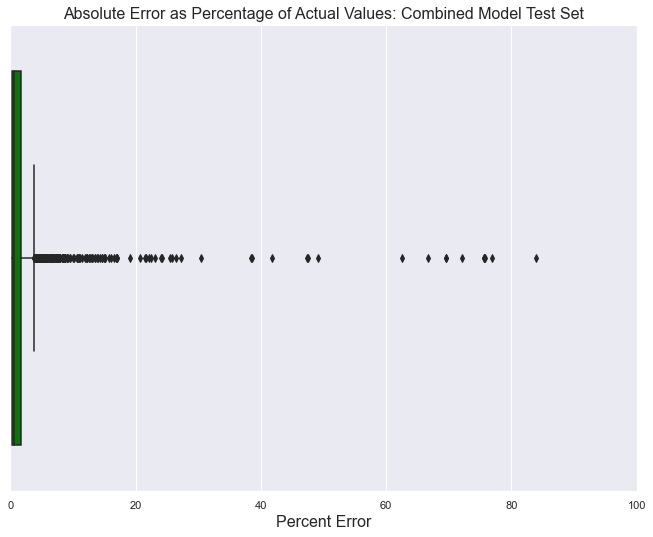

In [92]:
# create a boxplot
sns.boxplot(x=percent_error, color="green")

# add labels
plt.xlabel('Percent Error', fontsize=16)
plt.title("Absolute Error as Percentage of Actual Values: Combined Model Test Set", fontsize=16)
plt.xlim(0,100)


# display the plot
plt.show()

### Step 6.5: Combined Model Scatter Plot: Actual Line-Item Value vs. Predicted Line-Item Value

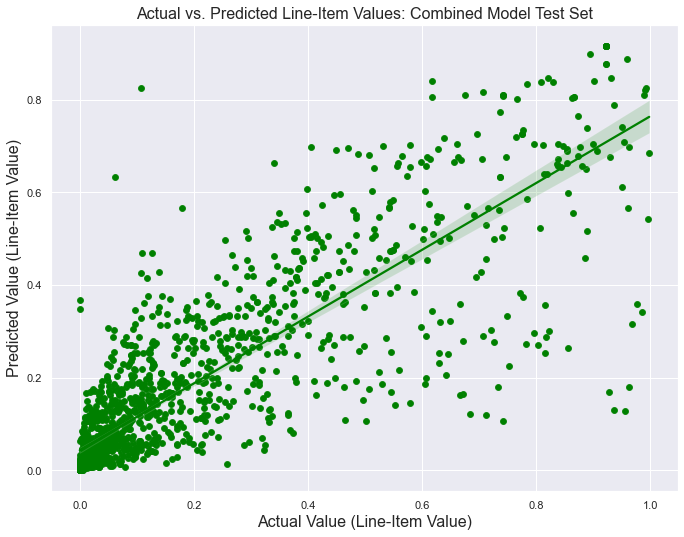

[CV] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.1s
[CV] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=2, mi

In [91]:
# scatter chart developed with the assistance of ChatGPT Mar 23, 2023 version

# create data for example
actual_values = y_test
predicted_values = ((grid_search_rf.predict(X_test) + neigh_model_tuned.predict(X_test)) / 2)


# Set the figure size
sns.set(rc={"figure.figsize":(10, 8)})

# create scatter plot using Seaborn
sns.scatterplot(x=actual_values, y=predicted_values, color='green')

# add regression line
sns.regplot(x=actual_values, y=predicted_values, color='green')



# add title and axis labels
plt.title("Actual vs. Predicted Line-Item Values: Combined Model Test Set", fontsize=16)
plt.xlabel("Actual Value (Line-Item Value)", fontsize=16)
plt.ylabel("Predicted Value (Line-Item Value)", fontsize=16)


# display the plot
plt.show()